In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

graph_builder = StateGraph(State)

In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
llm = ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000018C0989DF10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018C099A89E0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000018C099E1DC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018C099E22A0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

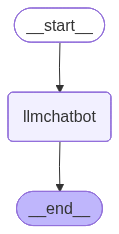

In [10]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
response=graph.invoke({"messages":"Hairs"})

In [12]:
response["messages"][-1].content

"Hairs are a fascinating part of human anatomy. Here are some interesting facts about hairs:\n\n1. **Structure**: Hairs are made up of a protein called keratin, which is also found in nails and skin. They have three layers: the medulla, the cortex, and the cuticle.\n2. **Types**: There are two main types of hairs: terminal hairs and vellus hairs. Terminal hairs are thick and coarse, while vellus hairs are thin and soft.\n3. **Functions**: Hairs serve several purposes, including:\n * Protecting the skin from the sun and cold temperatures\n * Helping to regulate body temperature\n * Providing sensory input (e.g., the sensation of touch and texture)\n * Aiding in the production of hormones (e.g., testosterone and estrogen)\n4. **Growth**: Hairs grow from the root, which is embedded in the skin. The growth cycle of a hair is divided into three phases:\n * Anagen phase (growth phase): 2-6 years\n * Catagen phase (transition phase): 2-3 weeks\n * Telogen phase (resting phase): 3-4 months\n5.

In [13]:
for event in graph.stream({"messages":"Hairs are filamentous structures that grow from the skin of most vertebrates"}):
    for value in event.values():
        print(value["messages"][-1].content)

That's correct. Hairs, or more specifically, hairs on mammals, are filamentous structures that grow from the skin of most vertebrates, particularly mammals. They are made up of a tough protein called keratin and serve several purposes, including:

1. Regulation of body temperature: Hairs help to insulate the body and regulate its temperature.
2. Protection: Hairs provide a physical barrier against external factors such as wind, sun, and cold temperatures.
3. Sensory function: Some hairs, such as those on the face and head, are sensitive to touch and help to detect changes in the environment.
4. Social and sexual signaling: Hairs can also play a role in social and sexual signaling, such as in the display of dominance or attractiveness.

In addition to mammals, some other vertebrates, such as birds and reptiles, also have hair-like structures, although they are not as prominent or diverse as those found in mammals.


In [14]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://langchain-ai.github.io/langgraph/',
   'title': 'LangGraph - GitHub Pages',
   'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents. LangGraph is very low-level, and focused entirely on agent **orchestration**. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools. LangGraph is focused on the underlying capabilities important for agent orchestration: durable execution, streaming, human-in-the-loop, and more. LangGraph provides low-level supporting infrastructure for *any* long-running, stateful workflow or agent. While LangGraph can be used standalone, it also integrates seamlessly with any LangCh

In [15]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [16]:
tools=[tool,multiply]

In [17]:
llm_with_tool=llm.bind_tools(tools)

In [18]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000018C099E1DC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018C099E22A0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

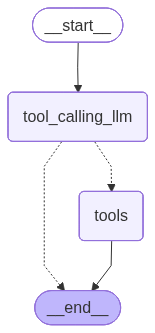

In [19]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [20]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [21]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.consultancy-me.com/news/12021/next-wave-of-global-ai-innovation-to-shift-investments-toward-the-global-south", "title": "Next wave of global AI innovation to shift investments toward the Global South - Consultancy-me.com", "score": 0.70871735, "published_date": "Tue, 04 Nov 2025 12:15:00 GMT", "content": "09 September 2025\\n\\nGrowth consultancy MomentumABM joins Accenture Song   Accenture has acquired MomentumABM for an undisclosed fee. The UK-headquartered growth consultancy will become part of creative agency Accenture Song, adding around 90 experts in Britain and the US. \\n\\n05 September 2025\\n\\n## AI & Gen AI news\\n\\nAI & Gen AI consulting firms AI & Gen AI consulting services [...] 04 November 2025\\n Enterprise AI platform HUMAIN ONE launches with strategic partners EY, Groq and Replit   HUMAIN, a global AI-tech company backed by the Public Investment F

In [22]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (n08ha2xkp)
 Call ID: n08ha2xkp
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.consultancy-me.com/news/12021/next-wave-of-global-ai-innovation-to-shift-investments-toward-the-global-south", "title": "Next wave of global AI innovation to shift investments toward the Global South - Consultancy-me.com", "score": 0.70871735, "published_date": "Tue, 04 Nov 2025 12:15:00 GMT", "content": "09 September 2025\n\nGrowth consultancy MomentumABM joins Accenture Song   Accenture has acquired MomentumABM for an undiscl

In [23]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (m95d2m5m1)
 Call ID: m95d2m5m1
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [24]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (9a65jmbgw)
 Call ID: 9a65jmbgw
  Args:
    query: recent ai news
    time_range: day
    topic: news
  multiply (f7d6yw5pw)
 Call ID: f7d6yw5pw
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://abcnews.go.com/Business/wireStory/asian-shares-trade-lower-after-ai-darlings-prop-127159115", "title": "Asian shares trade lower after AI darlings prop up Wall Street - ABC News", "score": 0.60861784, "published_date": "Tue, 04 Nov 2025 07:39:16 GMT", "content": "Asian shares have retreated despite the big lift in overseas markets from optimism over AI technology 